# Comparision of methods for time delay estimation on real pairs of event-based time-series data

**Methods:**
1. Nearest Advocate (NAd): dense, different sparse-factors  
1. Pearson Cross-correlation (PCC): FFT and DFT  
1. Kernel Cross-correlation (KCC)  
1. Dynamic Time Warping (DTW)  

**Experiments:**
1. Sample different lenghts for each data type

## TODO

- [x] Update DTW method from other
- [ ] get already synched data for BR and SR
- [x] Clarify if simulated data is okay for length-experiment
- [x] Clarify if we should use NAd with multiple sparse-factor at first and then only dense and optimal sparse-factor?
- [ ] Clarify which method we should evaluate
- [x] Clarify which plots we should unify
- [x] Wording MAE mean absolute error instead of precision (higher is worse here)
- [x] Parallelize the calculation
- [x] Implement PCC
- [x] Implement KCC
- [x] Implement DTW
- [x] Robustness Experiment (variable noise)
- [x] Robustness Experiment (missing events)
- [x] Fixate colors to methods
- [x] What about styles?

In [1]:
import os
# Set the path such that the package can be found locally
os.chdir("/home/jovyan/work/Synchronization/git_nearest_advocate/experiments/")
import time

import numpy as np
np.random.seed(0)
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from multiprocessing import Pool

# Load methods
%matplotlib inline

In [2]:
# importer for the methods, styles and data
from config import colorscheme
from methods import modify_timeseries, nearest_advocate, pearson_cc, kernel_cc, dynamic_linear_timewarping
from data_loader import load_heart_beats, load_breath_rate, load_step_rate

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
# directories to load
PATH_HEART_RATE_DATA = "../data/HeartBeatData"
PATH_BREATH_RATE_DATA = "../data/BreathRateData"
PATH_STEP_RATE_DATA = "../data/StepRateData"

# parameters to semi-simulate data
SIGMA = 0.1

# parameters for Nearest-Advocate
DIST_MAX = -1           # use the default values for dist_max of nearest_advocate
TD_MAX = 300               # search space of 10 minutes
TD_MIN = -300
SAMPLES_PER_S = 10        # precision of the search space (for steps of mean freq 0.5s)

## Data

### Load the datasets

In [4]:
heart_beat_dataset = load_heart_beats(path_to_dir=PATH_HEART_RATE_DATA, verbose=1)

Loading files S18_11_nn.txt and S18_1_beats_synced.csv.
Loading files S18_21_nn.txt and S18_2_beats_synced.csv.
Loading files S19_11_nn.txt and S19_1_beats_synced.csv.
Loading files S20_11_nn.txt and S20_1_beats_synced.csv.
Loading files S20_21_nn.txt and S20_2_beats_synced.csv.
Loading files S21_11_nn.txt and S21_1_beats_synced.csv.
Loading files S21_21_nn.txt and S21_2_beats_synced.csv.
Loading files S23_11_nn.txt and S23_1_beats_synced.csv.
Loading files S23_21_nn.txt and S23_2_beats_synced.csv.
Loading files S24_11_nn.txt and S24_1_beats_synced.csv.
Loading files S24_21_nn.txt and S24_2_beats_synced.csv.
Loading files S26_11_nn.txt and S26_1_beats_synced.csv.
Loading files S27_11_nn.txt and S27_1_beats_synced.csv.
Loading files S28_11_nn.txt and S28_1_beats_synced.csv.
Loading files S28_21_nn.txt and S28_2_beats_synced.csv.
Loading files S29_11_nn.txt and S29_1_beats_synced.csv.
Loading files S29_21_nn.txt and S29_2_beats_synced.csv.


In [5]:
breath_rate_dataset = load_breath_rate(path_to_dir=PATH_BREATH_RATE_DATA, verbose=1)

Loading files P05_Reference_FlowReversals_OVERALL.csv and P05_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P06_Reference_FlowReversals_OVERALL.csv and P06_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P07_Reference_FlowReversals_OVERALL.csv and P07_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P08_Reference_FlowReversals_OVERALL.csv and P08_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P09_Reference_FlowReversals_OVERALL.csv and P09_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P10_Reference_FlowReversals_OVERALL.csv and P10_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P11_Reference_FlowReversals_OVERALL.csv and P11_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P12_Reference_FlowReversals_OVERALL.csv and P12_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P13_Reference_FlowReversals_OVERALL.csv and P13_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P14_Reference_FlowReversals_OVERALL.csv and P14_SportsSRS_FlowReversals_OVERALL.csv.
Loading fi

In [6]:
step_rate_dataset = load_step_rate(path_to_dir=PATH_STEP_RATE_DATA, verbose=1)

Loading files P04_Reference_Strides_OVERALL.csv and P04_SportsSRS_Strides_OVERALL.csv.
Loading files P06_Reference_Strides_OVERALL.csv and P06_SportsSRS_Strides_OVERALL.csv.
Loading files P07_Reference_Strides_OVERALL.csv and P07_SportsSRS_Strides_OVERALL.csv.
Loading files P08_Reference_Strides_OVERALL.csv and P08_SportsSRS_Strides_OVERALL.csv.
Loading files P09_Reference_Strides_OVERALL.csv and P09_SportsSRS_Strides_OVERALL.csv.
Loading files P10_Reference_Strides_OVERALL.csv and P10_SportsSRS_Strides_OVERALL.csv.
Loading files P11_Reference_Strides_OVERALL.csv and P11_SportsSRS_Strides_OVERALL.csv.
Loading files P12_Reference_Strides_OVERALL.csv and P12_SportsSRS_Strides_OVERALL.csv.
Loading files P13_Reference_Strides_OVERALL.csv and P13_SportsSRS_Strides_OVERALL.csv.
Loading files P16_Reference_Strides_OVERALL.csv and P16_SportsSRS_Strides_OVERALL.csv.
Loading files P18_Reference_Strides_OVERALL.csv and P18_SportsSRS_Strides_OVERALL.csv.
Loading files P19_Reference_Strides_OVERALL

## Function to semi-simulate the data

In [7]:
modify_timeseries(arr=heart_beat_dataset[0][0], offset=np.pi, subselect_length=10, sigma=0.1, fraction=0.5,
                  time_warp_scale=0.005)

array([1985.2642013 , 1985.94322342, 1987.22308435, 1988.86971251,
       1990.34830416])

In [8]:
#  DTW yields more robust results for time-series shorter than 500 events using a higher overlap (/4)
def get_offset(length):
    l_bound, u_bound = max(TD_MIN, -length/2), min(TD_MAX, length/2)
    return np.random.random() * (u_bound-l_bound) + l_bound

def get_offset_array(array):
    l_bound = max(TD_MIN, -len(array)/2, -SUBSELECT_LENGTH/2)
    u_bound = min(TD_MAX, len(array)/2, SUBSELECT_LENGTH/2)
    return np.random.random() * (u_bound-l_bound) + l_bound

## Define Methods

### Nearest Advocate

Found optimum for a time shift of 31.420s in 1.920s


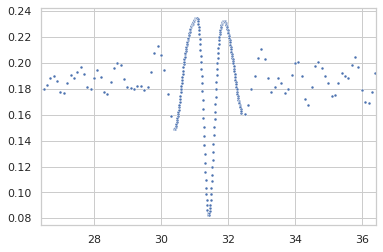

In [9]:
# run once before the test to just-in-time compile it
start_time = time.time()
arr_ref = np.cumsum(np.random.normal(loc=1, scale=0.25, size=1000))
arr_sig = modify_timeseries(arr=arr_ref, offset=10*np.pi, sigma=0.1, fraction=0.99,
                           time_warp_scale=0.00, subselect_length=100)
time_delays = nearest_advocate(arr_ref=arr_ref, arr_sig=arr_sig,
                             td_min=-100, td_max=100, td_prox=1, sps=SAMPLES_PER_S, sparse_factor=1,
                             dist_max=DIST_MAX)
time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
print(f"Found optimum for a time shift of {time_shift:.3f}s in {time.time()-start_time:.3f}s")

sns.scatterplot(x=time_delays[:,0], y=time_delays[:,1], marker='.')
plt.xlim(time_shift-5.0, time_shift+5.0)
plt.show()

### Cross-Correlation

Found optimum at 31.400s with value 0.4921


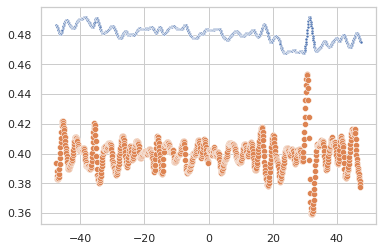

In [10]:
arr_ref = np.cumsum(np.random.normal(loc=1, scale=0.25, size=1000))
arr_sig = modify_timeseries(arr=arr_ref, offset=10*np.pi, sigma=0.1, fraction=0.99,
                           time_warp_scale=0.00, subselect_length=100)
time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, mode="same", method="fft")
# time_shift, metric = time_delays[np.argmax(time_delays[:,1])]
print(f"Found optimum at {time_shift:.3f}s with value {metric:.4f}")

sns.scatterplot(x=time_delays[:,0], y=time_delays[:,1], marker='.')
sns.scatterplot(x=time_delays[:-1,0], y=0.4+25*np.diff(time_delays[:,1]))
plt.show()

### Kernel Cross-Correlation

Found optimum at 31.400s with value 48.5000


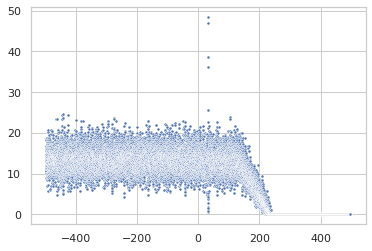

In [11]:
arr_ref = np.cumsum(np.random.normal(loc=1, scale=0.25, size=1000))
arr_sig = modify_timeseries(arr=arr_ref, offset=10*np.pi, sigma=0.1, fraction=0.99,
                           time_warp_scale=0.00, subselect_length=100)
time_shift, metric, time_delays = kernel_cc(arr_ref, arr_sig, mode="same", method="fft", kernel_width=0.2)
print(f"Found optimum at {time_shift:.3f}s with value {metric:.4f}")

sns.scatterplot(x=time_delays[:,0], y=time_delays[:,1], marker='.')
plt.show()

### Dynamic Linear Timewarping

Found resulting median shift of 31.500s in 0.0093153s


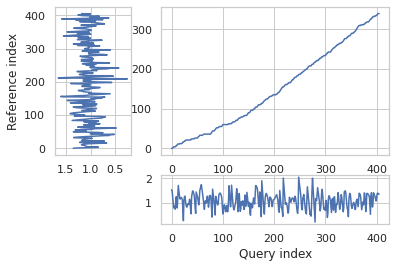

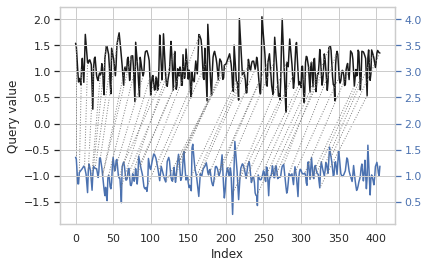

In [12]:
start_time = time.time()
arr_ref = np.cumsum(np.random.normal(loc=1, scale=0.25, size=1000))
arr_sig = modify_timeseries(arr=arr_ref, offset=10*np.pi, sigma=0.2, fraction=0.99,
                           time_warp_scale=0.00, subselect_length=200)

#distance, warped_path, element_shift, median_element_shift, time_shift, median_time_shift = dynamic_linear_timewarping(arr_ref, arr_sig)
time_shift, alignment = dynamic_linear_timewarping(arr_ref, arr_sig)
print(f"Found resulting median shift of {time_shift:.3f}s in {time.time()-start_time:.5g}s")

# Plot with the Rabiner-Juang type VI-c unsmoothed recursion
alignment.plot(type="threeway")
alignment.plot(type="twoway",offset=-2)
plt.show()

## Experiment 1 for HB: Precision by Length

The time-series is sampled from the real data pairs and the signal array is constrained by length

In [13]:
LENGTHS = [int(l) for l in [1e1, 2e1, 5e1, 1e2, 2e2, 5e2, 1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5, 1e6]]
MEASUREMENTS = heart_beat_dataset  # (heart_beat_dataset + breath_rate_dataset + step_rate_dataset)

# limit lengths to maximal length of data
min_length = np.min([min(len(pair[0]), len(pair[1])) for pair in MEASUREMENTS])
LENGTHS = [l for l in LENGTHS if l < min_length]
print(LENGTHS)

METHODS = ['NAd-dense', 'NAd-sparse10', 'NAd-sparse100', 'PCC-FFT', 'PCC-FFT-smooth',  'KCC-1', 'KCC-0.5', 'DTW-asym']
# don't use PCC-DFT here as it uses multiple cores by default

MAX_TIMEOUT = 3  # maximal wait time to ignore the method afterwards
ignore_method_timeout = {k: False for k in ['DTW-asym']}

[10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]


In [14]:
# evaluate a given length
def evaluate_length(length):
    # parse pairs of measurements
    data_pairs = list()
    n_measurements = 0
    offset = 0
    for array_ref, array_sig in MEASUREMENTS:
        data_pairs.append((array_ref,
                           modify_timeseries(arr=array_sig, subselect_length=length)))
        data_pairs.append((array_sig,
                           modify_timeseries(arr=array_ref, subselect_length=length)))
        n_measurements += 2
    assert n_measurements == 2 * len(MEASUREMENTS)  # otherwise there ar !=2 arrays per measurement

    # define the local DataFrame for one single pair
    df_precision = pd.DataFrame({m: np.nan*np.zeros(n_measurements) for m in METHODS})
    df_precision["length"] = [length for _ in range(n_measurements)]

    # loop through all data pairs
    for idx, (arr_ref, arr_sig) in enumerate(data_pairs):
        # NAd-dense
        time_delays = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig,
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=1,
            dist_max=DIST_MAX)
        time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
        df_precision.loc[idx, "NAd-dense"] = np.abs(time_shift)

        # NAd-sparse10
        time_delays = nearest_advocate(
            arr_ref=arr_ref, arr_sig=arr_sig,
            td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=10,
            dist_max=DIST_MAX)
        time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
        df_precision.loc[idx, "NAd-sparse10"] = np.abs(time_shift)

        # NAd-sparse100
        try:
            time_delays = nearest_advocate(
                arr_ref=arr_ref, arr_sig=arr_sig,
                td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, sparse_factor=100,
                dist_max=DIST_MAX)
            time_shift, min_mean_dist = time_delays[np.argmin(time_delays[:,1])]
            df_precision.loc[idx, "NAd-sparse100"] = np.abs(time_shift)
        except AssertionError:
            pass
            # print(f"WARNING: AssertionError, skipping.")

        # PCC-FFT
        try:
            time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, method="fft")
            df_precision.loc[idx, "PCC-FFT"] = np.abs(time_shift)
        except:
            pass

        # PCC-FFT-smooth
        try:
            time_shift, metric, time_delays = pearson_cc(arr_ref, arr_sig, method="fft", smooth_outliers=True)
            df_precision.loc[idx, "PCC-FFT-smooth"] = np.abs(time_shift)
        except:
            pass

        # KCC-0.5
        try:
            time_shift, metric, time_delays =  kernel_cc(arr_ref, arr_sig, method="fft", kernel_width=0.5)
            df_precision.loc[idx, "KCC-0.5"] = np.abs(time_shift)
        except:
            pass
        # KCC-1
        try:
            time_shift, metric, time_delays =  kernel_cc(arr_ref, arr_sig, method="fft", kernel_width=1.0)
            df_precision.loc[idx, "KCC-1"] = np.abs(time_shift)
        except:
            pass

        # DTW-asym
        try:
            if not ignore_method_timeout["DTW-asym"]:
                start_time = time.time()
                time_shift, alignment = dynamic_linear_timewarping(arr_ref, arr_sig)
                df_precision.loc[idx, "DTW-asym"] = np.abs(time_shift)
                if time.time() - start_time > MAX_TIMEOUT:
                    ignore_method_timeout["DTW-asym"] = True
        except:
            pass

    return df_precision

# Initialize the pool with the number of processes
with Pool(processes=30) as pool:
    results = pool.map(evaluate_length, LENGTHS)
df_precision = pd.concat(results).sort_values("length")
df_precision.sample(5)

,NAd-dense,NAd-sparse10,NAd-sparse100,PCC-FFT,PCC-FFT-smooth,KCC-1,KCC-0.5,DTW-asym,length
8,0.416000,0.416000,0.444000,1.5,1.5,0.45,0.40,NaN,10000
10,0.044000,216.675995,261.799988,25.7,22.4,7774.70,0.05,0.0,100
3,0.056495,0.056495,0.066495,0.2,0.1,0.10,0.10,NaN,5000
14,0.012000,0.012000,0.022000,8119.1,7900.3,0.05,0.05,NaN,20000
14,2.708000,1.768000,149.362000,1259.1,0.7,2.05,2.05,NaN,5000


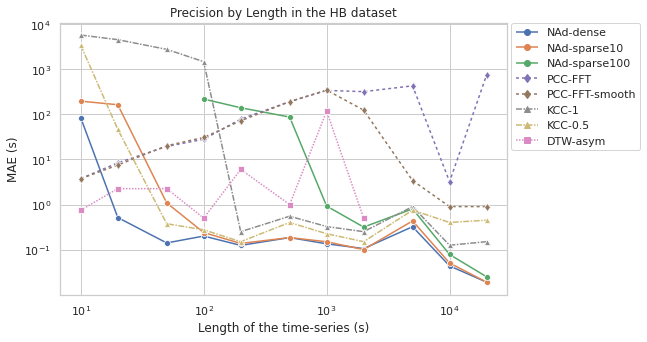

In [15]:
fig, axes = plt.subplots(1,1, figsize=(8, 5))

# melt the DataFrame
df_precision_melted = pd.melt(df_precision, id_vars="length", var_name="Method",
                              value_vars=METHODS, value_name="precision")

precision_plot = sns.lineplot(data=df_precision_melted[df_precision_melted["precision"] != 0],
                              x="length", y="precision",
                              hue="Method", style="Method",
                              markers={m: colorscheme[m]["p"] for m in METHODS},
                              dashes={m: colorscheme[m]["l"] for m in METHODS},
                              palette={m: colorscheme[m]["c"] for m in METHODS},
                              estimator=np.median, errorbar=None)
# lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)))
plt.title("Precision by Length in the HB dataset")
plt.xlabel("Length of the time-series (s)")
plt.ylabel("MAE (s)")
# plt.ylim((0.02, 50))
precision_plot.set(xscale='log')
precision_plot.set(yscale='log')
plt.legend(loc=(1.01, 0.53))
plt.savefig("fig/realpairs_precision_length_HB.png")
plt.show()

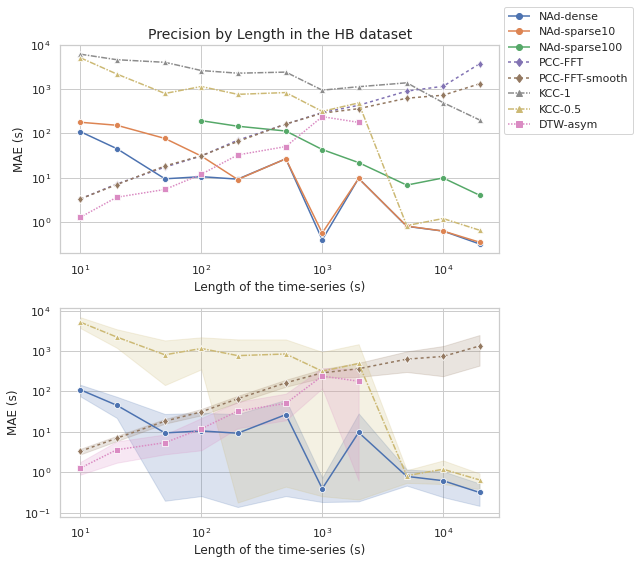

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(9,8))
axes[0].set_title("Precision by Length in the HB dataset", size=14)

# melt the DataFrame
df_precision_melted = pd.melt(df_precision, id_vars="length", var_name="Method",
                              value_vars=METHODS, value_name="precision")

precision_plot = sns.lineplot(data=df_precision_melted[df_precision_melted["precision"] != 0],
                              x="length", y="precision",
                              hue="Method", style="Method",
                              markers={m: colorscheme[m]["p"] for m in METHODS},
                              dashes={m: colorscheme[m]["l"] for m in METHODS},
                              palette={m: colorscheme[m]["c"] for m in METHODS},
                              estimator=np.mean, errorbar=None,
                              ax=axes[0])
axes[0].set_xlabel("Length of the time-series (s)")
axes[0].set_ylabel("MAE (s)")
precision_plot.set(xscale='log')
precision_plot.set(yscale='log')

# melt the DataFrame
df_precision_melted = pd.melt(df_precision, id_vars="length", var_name="Method",
                              value_vars=METHODS, value_name="precision")
df_precision_melted = df_precision_melted[df_precision_melted["Method"].apply(
    lambda m: m in ["NAd-dense", "PCC-FFT-smooth", "KCC-0.5", "DTW-asym"])]
precision_plot = sns.lineplot(data=df_precision_melted[df_precision_melted["precision"] != 0],
                              x="length", y="precision",
                              hue="Method", style="Method",
                              markers={m: colorscheme[m]["p"] for m in METHODS},
                              dashes={m: colorscheme[m]["l"] for m in METHODS},
                              palette={m: colorscheme[m]["c"] for m in METHODS},
                              estimator=np.mean, errorbar=("ci", 95))
axes[1].set_xlabel("Length of the time-series (s)")
axes[1].set_ylabel("MAE (s)")
precision_plot.set(xscale='log')
precision_plot.set(yscale='log')

axes[0].legend(loc=(1.01, 0.57))
axes[1].get_legend().remove()
fig.tight_layout()
plt.savefig("fig/realpairs_precision_length_HB_selected.png")
plt.savefig("fig/realpairs_precision_length_HB_selected.pdf")
plt.show()

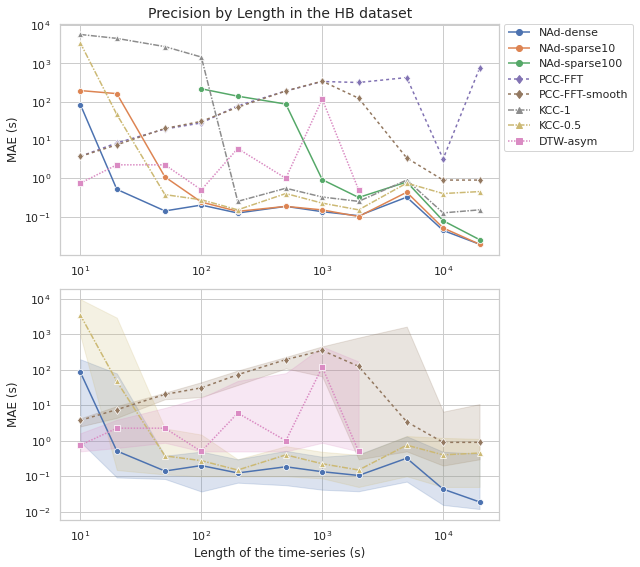

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(9,8))
axes[0].set_title("Precision by Length in the HB dataset", size=14)

# melt the DataFrame
df_precision_melted = pd.melt(df_precision, id_vars="length", var_name="Method",
                              value_vars=METHODS, value_name="precision")

precision_plot = sns.lineplot(data=df_precision_melted[df_precision_melted["precision"] != 0],
                              x="length", y="precision",
                              hue="Method", style="Method",
                              markers={m: colorscheme[m]["p"] for m in METHODS},
                              dashes={m: colorscheme[m]["l"] for m in METHODS},
                              palette={m: colorscheme[m]["c"] for m in METHODS},
                              estimator=np.median, errorbar=None,
                              ax=axes[0])
axes[0].set_xlabel("")  # "Length of the time-series (s)"
axes[0].set_ylabel("MAE (s)")
precision_plot.set(xscale='log')
precision_plot.set(yscale='log')

# melt the DataFrame
df_precision_melted = pd.melt(df_precision, id_vars="length", var_name="Method",
                              value_vars=METHODS, value_name="precision")
df_precision_melted = df_precision_melted[df_precision_melted["Method"].apply(
    lambda m: m in ["NAd-dense", "PCC-FFT-smooth", "KCC-0.5", "DTW-asym"])]
precision_plot = sns.lineplot(data=df_precision_melted[df_precision_melted["precision"] != 0],
                              x="length", y="precision",
                              hue="Method", style="Method",
                              markers={m: colorscheme[m]["p"] for m in METHODS},
                              dashes={m: colorscheme[m]["l"] for m in METHODS},
                              palette={m: colorscheme[m]["c"] for m in METHODS},
                              estimator=np.median, errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)))
axes[1].set_xlabel("Length of the time-series (s)")
axes[1].set_ylabel("MAE (s)")
precision_plot.set(xscale='log')
precision_plot.set(yscale='log')

axes[0].legend(loc=(1.01, 0.45))
axes[1].get_legend().remove()
fig.tight_layout()
plt.savefig("fig/realpairs_precision_length_HB_selected.png")
plt.savefig("fig/realpairs_precision_length_HB_selected.pdf")
plt.show()